In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19_Radiography_Dataset"

Mounted at /content/gdrive
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'


In [2]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)     

<IPython.core.display.Javascript object>

In [3]:
# import packages

import tensorflow as tf
from keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import graphviz
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense



# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

chest_xray_dataset = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/images")
chest_xray_dataset_annotations = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/metadata.csv")
radiography_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19_Radiography_Dataset/")
xray_covid19_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19/")


In [4]:
imageDf = pd.read_csv(chest_xray_dataset_annotations)
print(imageDf.finding)

0      COVID-19
1      COVID-19
2      COVID-19
3      COVID-19
4      COVID-19
         ...   
367    COVID-19
368    COVID-19
369    COVID-19
370    COVID-19
371    COVID-19
Name: finding, Length: 372, dtype: object


In [5]:
# used following resource for ref https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
# Decided to use target size of 1024, 1024 for padding as there isn't a consistent resolution

image_size = (512, 512)
batch_size = 4
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator=datagen.flow_from_dataframe(dataframe=imageDf, directory=chest_xray_dataset, x_col="filename", y_col="finding", class_mode="categorical", target_size=image_size, batch_size=batch_size, subset='training',crop_to_aspect_ratio=True)
validation_generator = datagen.flow_from_dataframe(dataframe=imageDf, directory=chest_xray_dataset, x_col="filename", y_col="finding", class_mode="categorical", target_size=image_size, batch_size=batch_size,subset='validation',crop_to_aspect_ratio=True)
print('test',validation_generator)


Found 316 validated image filenames belonging to 11 classes.
Found 35 validated image filenames belonging to 11 classes.
test <keras.preprocessing.image.DataFrameIterator object at 0x7fdd27defd60>


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 21 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


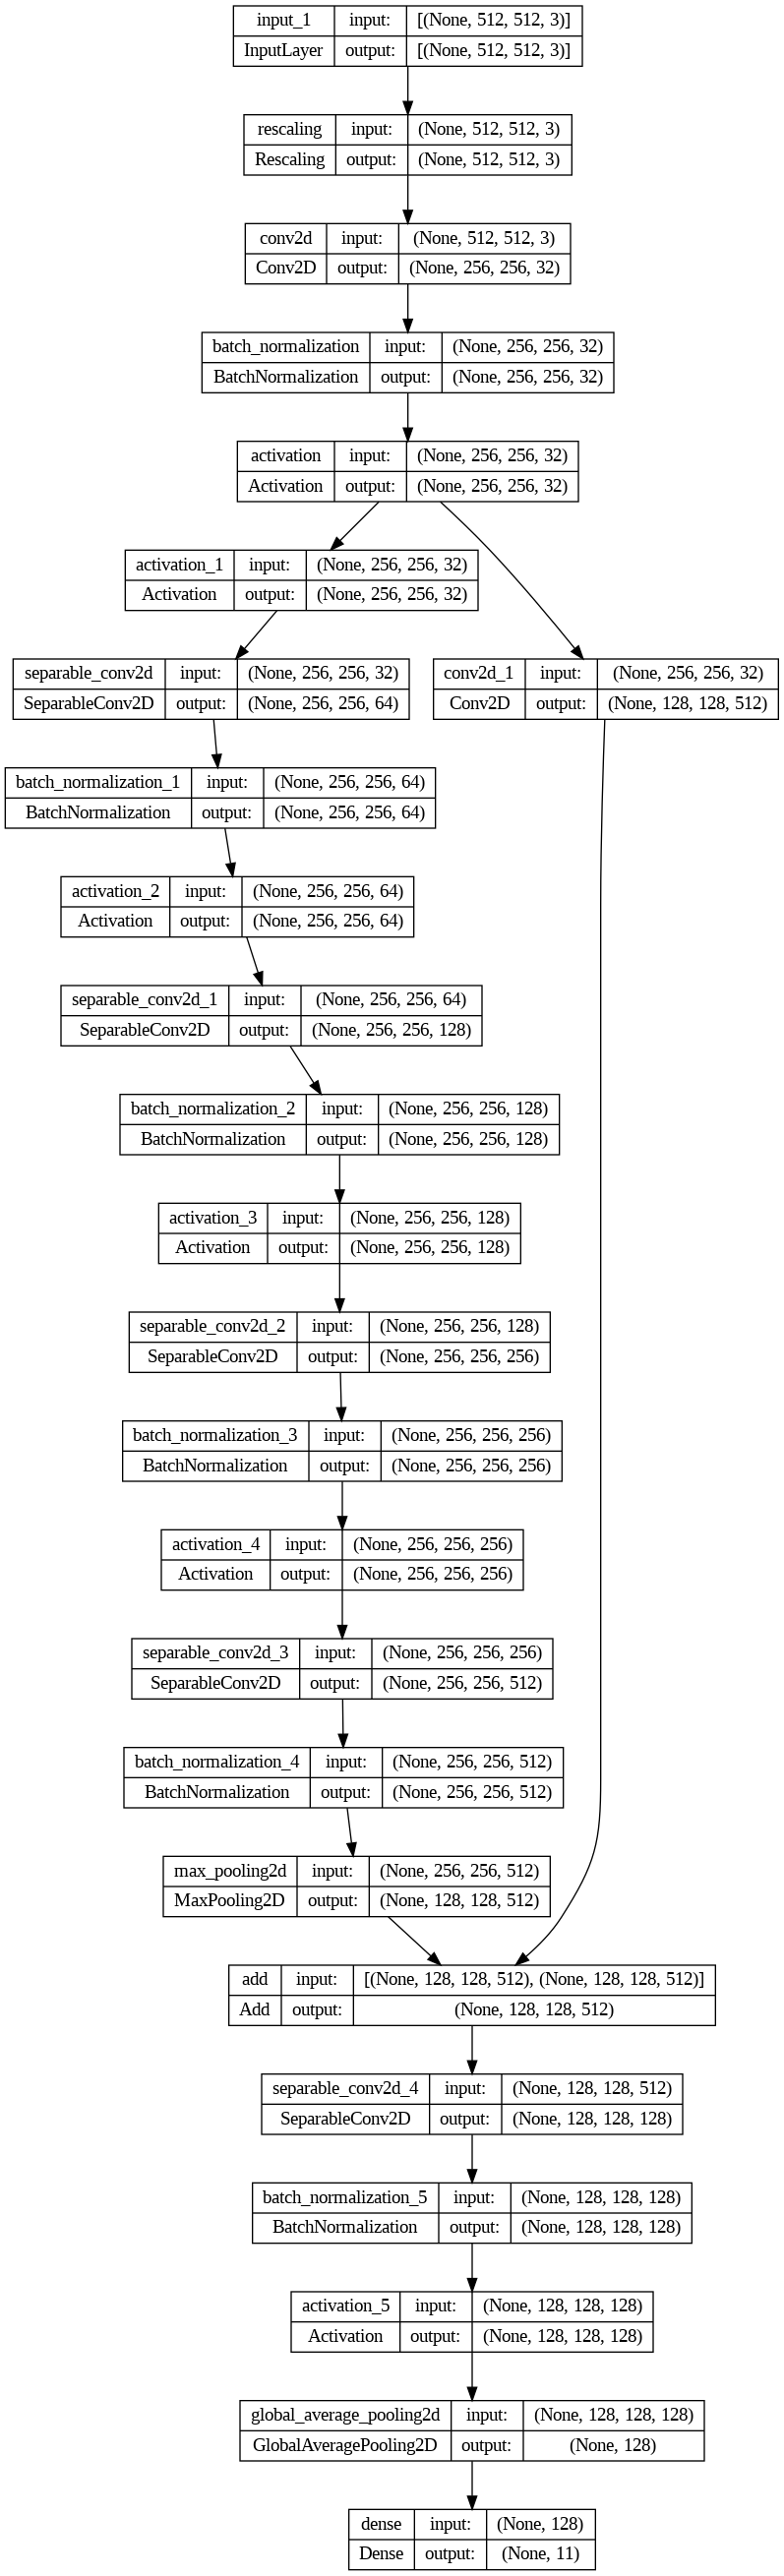

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    
    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    
    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(512, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    layers.Dropout(0.2)
    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = 11

    outputs = layers.Dense(11, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=11)
keras.utils.plot_model(model, show_shapes=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

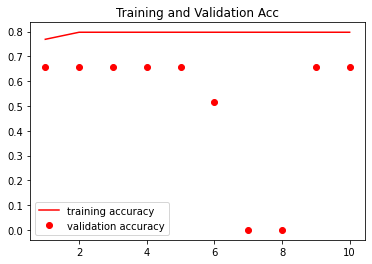

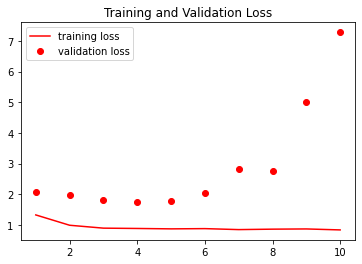

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/chest_xray_dataset_model.h5')
print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Transfer Learning Models Baseline

In [6]:
input_shape = (512, 512,3)


83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 11)                11275     
                                                                 
Total params: 22,970,931
Trainable params: 22,916,403
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
79/79 [==============================] - 131s 1s/step - loss: 1.2733 - acc: 0.7880 - val_loss: 4.6813 - val_acc: 0.6571
Epoch 2/10
79/79 [==============================] - 18s 227ms/step - loss: 0.9964 - acc: 0.7975 - val_loss:

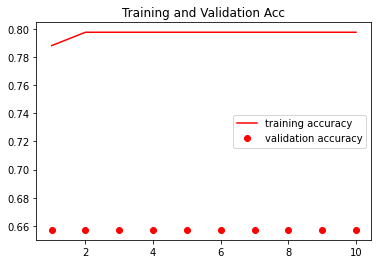

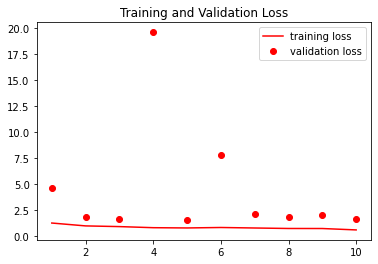

In [7]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk

Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling='avg',
    classes=11,
    classifier_activation="softmax",
)
Xception_model.add(model)
Xception_model.add(Dense(1024,activation='relu'))
Xception_model.add(Dense(11,activation='softmax'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="CategoricalCrossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_chest_xray_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 11)                11275     
                                                                 
Total params: 25,674,251
Trainable params: 25,628,811
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
79/79 [==============================] - 27s 247ms/step - loss: 1.4520 - acc: 0.7848 - val_loss: 39552.1016 - val_acc: 0.6571
Epoch 2/10
79/79 [==============================] - 18s 227ms/step - loss: 1.1751 - acc: 0.7975 - v

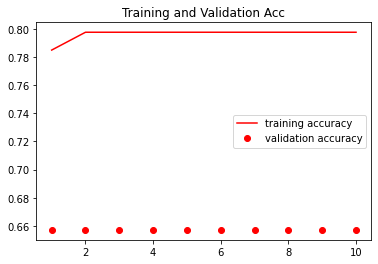

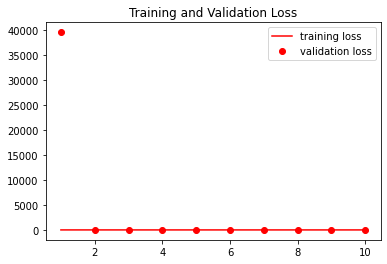

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling='avg',
    classes=11,
    classifier_activation="softmax",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(1024,activation='relu'))
ResnetModel50V2_model.add(Dense(11,activation='softmax'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="CategoricalCrossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_chest_xray_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

82420632/82420632 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_6 (Dense)             (None, 11)                11275     
                                                                 
Total params: 21,654,379
Trainable params: 21,500,507
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/10
79/79 [==============================] - 48s 304ms/step - loss: 3.2023 - acc: 0.7152 - val_loss: 2.0404 - val_acc: 0.6571
Epoch 2/10
79/79 [==================

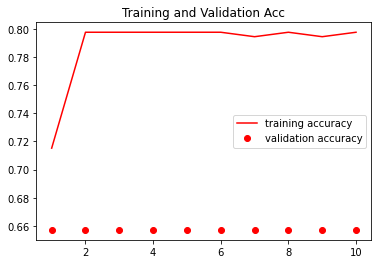

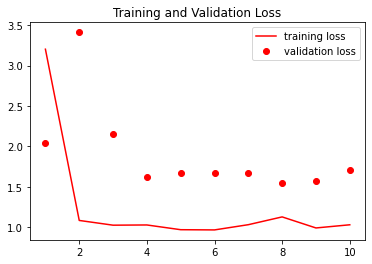

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling='avg',
    classes=11,
    classifier_activation="softmax",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(1024,activation='relu'))
EfficientNetV2S_model.add(Dense(11,activation='softmax'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="categorical_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_chest_xray_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()